In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import math
import seaborn as sns

%matplotlib widget

Duplicate key in file PosixPath('/opt/conda/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc'), line 271 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')
Duplicate key in file PosixPath('/opt/conda/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc'), line 411 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


# 1. Data Processing

## 1.1 Data Collection

There are currently two data sources:
- High availability prometheus thanos
- Operational data elasticsearch

At present, the offline evaluation data uses the prometheus python client to directly obtain raw data.

## 1.2 EDA(Exploratory data analysis)

In [4]:
'''
Data clean function collection.
'''

# avoid not same namespace but same name
# max cpu usage less than 0.05 is dropped.
def choose_cpu_usage_column_name(df):
    columns = df.columns
    sequence = "cpu_usage"
    for c in columns:
        if (sequence in c):
            return c
    return "not found"

def load_csv_data(csv_path):
    raw = pd.read_csv(csv_path)
    df = pd.DataFrame(data=raw)
    return raw, df


def clean_data(raw):
    df = pd.DataFrame(data=raw)
    # delete duplication name data
    unique_names = raw["prometheus.labels.owner_name"].unique()
    
    cpu_usage_column_name = choose_cpu_usage_column_name(df)
    needed_result_dict={}
    max_less_dict={}
    
    # delete max_cpu_usage is too small data, 0.05
    for i in range(len(unique_names)):
        data_by_name = df.loc[df['prometheus.labels.owner_name']==unique_names[i]]
        # index from 0 start
        data_by_name = data_by_name.reset_index()
        diff_ns = (data_by_name["prometheus.labels.namespace"].unique() != data_by_name[0:1]["prometheus.labels.namespace"])
        if diff_ns.bool() : print(diff_ns)
        data_by_name[cpu_usage_column_name] = [float(str(i).replace(",", "")) for i in data_by_name[cpu_usage_column_name]]
        seq_cpu_usage = data_by_name[cpu_usage_column_name]
        name = data_by_name["prometheus.labels.owner_name"][0]
        namespace = data_by_name["prometheus.labels.namespace"][0]
        namespaced_name = str(name)+"_"+str(namespace)
        # if cpu usage is too small, set it to zero, 0.0001
        seq_cpu_usage[seq_cpu_usage < 1e-4] = 0
        # cpu_usage is too small 
        if data_by_name[cpu_usage_column_name].max() < 0.05:
            max_less_dict[namespaced_name] = seq_cpu_usage
            continue
        needed_result_dict[namespaced_name] = seq_cpu_usage
    
    return needed_result_dict, max_less_dict
def choose_memory_usage_column_name(df):
    columns = df.columns
    sequence = "memory_usage"
    for c in columns:
        if (sequence in c):
            return c
    return "not found"

def clean_container_data_cpu_usage(raw):
    df = pd.DataFrame(data=raw)
    # delete duplication name data
    unique_names = raw["prometheus.labels.name"].unique()
    
    cpu_usage_column_name = choose_cpu_usage_column_name(df)
    needed_container_cpu_usage_dict={}
    max_less_container_cpu_usage_dict={}
    
    # delete max_cpu_usage is too small data, 0.05
    for i in range(len(unique_names)):
        data_by_name = df.loc[df['prometheus.labels.name']==unique_names[i]]
        # index from 0 start
        data_by_name = data_by_name.reset_index()
       
        diff_ns = (data_by_name["prometheus.labels.namespace"].unique() != data_by_name[0:1]["prometheus.labels.namespace"])
        if diff_ns.bool() : print(diff_ns)
        data_by_name[cpu_usage_column_name] = [float(str(i).replace(",", "")) for i in data_by_name[cpu_usage_column_name]]
        seq_cpu_usage = data_by_name[cpu_usage_column_name]
        name = data_by_name["prometheus.labels.container_name"][0]
        namespace = data_by_name["prometheus.labels.namespace"][0]
        namespaced_name = str(name)+"_"+str(namespace)+"_"+str(unique_names[i])
        # if cpu usage is too small, set it to zero, 0.0001
        seq_cpu_usage[seq_cpu_usage < 1e-4] = 0
        # cpu_usage is too small 
        if data_by_name[cpu_usage_column_name].max() < 0.05:
            max_less_container_cpu_usage_dict[namespaced_name] = seq_cpu_usage
            continue
        needed_container_cpu_usage_dict[namespaced_name] = seq_cpu_usage
    return needed_container_cpu_usage_dict, max_less_container_cpu_usage_dict

def clean_container_data_memory_usage(raw):
    df = pd.DataFrame(data=raw)
    # delete duplication name data
    unique_names = raw["prometheus.labels.name"].unique()
    
    memory_usage_column_name = choose_memory_usage_column_name(df)
    needed_container_memory_usage_dict={}
    max_less_container_memory_usage_dict={}
    
    # delete max_memory_usage is too small data, 50m
    for i in range(len(unique_names)):
        data_by_name = df.loc[df['prometheus.labels.name']==unique_names[i]]
        # index from 0 start
        data_by_name = data_by_name.reset_index()
        diff_ns = (data_by_name["prometheus.labels.namespace"].unique() != data_by_name[0:1]["prometheus.labels.namespace"])
        if diff_ns.bool() : print(diff_ns)
        data_by_name[memory_usage_column_name] = [float(str(i).replace(",", "")) for i in data_by_name[memory_usage_column_name]]
        seq_memory_usage = data_by_name[memory_usage_column_name]
        name = data_by_name["prometheus.labels.container_name"][0]
        namespace = data_by_name["prometheus.labels.namespace"][0]
        namespaced_name = str(name)+"_"+str(namespace)+"_"+str(unique_names[i])
        # if cpu usage is too small, set it to zero, 10m
        seq_memory_usage[seq_memory_usage < 10] = 0
        # cpu_usage is too small 
        if data_by_name[memory_usage_column_name].max() < 50:
            max_less_container_memory_usage_dict[namespaced_name] = seq_memory_usage
            continue
        needed_container_memory_usage_dict[namespaced_name] = seq_memory_usage
    
    return needed_container_memory_usage_dict, max_less_container_memory_usage_dict

In [5]:
'''
Load application data for evaluatation, only from two kubernetes clusters.
Here we have desensitized, so the above data processing method will not be used
'''
# from different cluster, all is 15 days data.
_,cpu_data_20220418_20220502_0a9obzx3 = load_csv_data("../../dataset/crane_production_cpu_series_data/cls-0a9obzx3_2022-04-18_2022-05-02_cpu_data.csv")
_, cpu_label_data_20220418_20220502_0a9obzx3 =load_csv_data("../../dataset/crane_production_cpu_series_data/cls-0a9obzx3_2022-04-18_2022-05-02_cpu_label_data.csv")

_, cpu_data_20220425_20220509_4g9b5b18 = load_csv_data("../../dataset/crane_production_cpu_series_data/cls-4g9b5b18_2022-04-25_2022-05-09_cpu_data.csv")
_, cpu_label_data_20220425_20220509_4g9b5b18 = load_csv_data("../../dataset/crane_production_cpu_series_data/cls-4g9b5b18_2022-04-25_2022-05-09_cpu_label_data.csv")

In [6]:
cpu_data_20220418_20220502_0a9obzx3

,name,0,1,2,3,4,5,6,7,8,...,43190,43191,43192,43193,43194,43195,43196,43197,43198,43199
0,5c6f227f72fcd3e8afa9bcecb750fcf39b29179672e0ec...,15.905731,15.905731,15.877003,15.904087,15.894917,15.893327,15.883926,15.926782,15.886019,...,15.894601,15.888646,15.896422,9.371555,12.615230,15.858904,15.858904,15.877051,15.895197,15.810820
1,f0bbceedc2a5e3b01ffb3458f3214d77d2b8199dfca4ec...,13.002207,13.002207,15.898139,15.901330,15.893603,15.887963,15.889745,15.908285,15.926825,...,15.899605,15.898133,15.893872,15.926628,15.759756,15.758746,15.921576,15.906562,15.903700,15.897042
2,bdcb18f3207e808034a406f7ddd0e07fa05a684555b549...,15.897643,15.891440,15.891553,15.890491,15.889430,15.888368,15.861042,15.881927,15.899435,...,15.736604,15.325692,15.488864,15.487845,15.447081,15.721077,15.473570,9.148252,14.947202,15.379461
3,141dc8fef7290f6836092124d7583e15432bf52ae6d863...,15.916290,15.892945,15.888390,15.897428,15.900345,15.874614,15.877744,15.880875,15.884005,...,15.908247,10.415479,14.939490,15.802357,15.909593,15.789532,15.892577,8.448858,15.030909,15.891068
4,daf1d37e9b90eb7eddbffbc22ee25300a4701e82f23fe9...,15.909098,15.904523,15.892445,15.903745,15.900111,15.885084,15.898483,15.880865,15.896084,...,15.891809,15.896533,15.866395,15.838297,15.911283,15.872857,15.903935,15.882912,15.894397,15.882978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,8a9765d187d5d003db4dc384872a03e28ae4dd0fc0917a...,6.204886,6.982862,7.743057,7.239710,6.959378,6.778657,6.643117,6.563317,6.320240,...,6.882953,6.971140,7.059327,7.147514,6.864462,6.957307,6.872295,6.879957,6.827847,6.889082
79,ed4c3dd43c4365924f7f6d6f7907c7c5b1deb82b625c84...,6.109378,7.516785,7.529054,7.023784,6.780328,6.714584,6.436675,6.458767,6.272877,...,6.832295,6.896863,6.922290,6.997795,6.876322,6.891447,6.827882,6.828145,6.725867,6.833810
80,21fa5f3889edba780731baf86488f4d032521641502771...,6.020298,6.079919,7.599043,7.336611,6.594916,6.594916,6.610365,6.625814,6.163793,...,6.688571,6.630692,6.748179,6.748179,6.671557,6.594935,6.594935,6.610860,6.626784,6.606681
81,0db643fe18da9f0c61c915afcf23881264e7fc390b2301...,6.009418,6.551420,7.627280,7.200889,6.749594,6.602527,6.361942,6.494897,6.181675,...,6.665071,6.760548,6.711333,7.107002,6.675252,6.749501,6.660822,7.001577,6.595190,6.668110


In [7]:
cpu_label_data_20220418_20220502_0a9obzx3

,name,is_cycle
0,95a74d1ea07429f490933b60e7038d2f9a58c5e9507742...,0
1,6b8c09b421e9baa7aa7bb37062fc19a0601e90ee8ae416...,1
2,ca60177259e3fe7d14814f2e82eb38b2b820bde80d2fdc...,1
3,b928d76aab4ffe8452d7cc610f28da376dee8d8208491b...,1
4,db898ddca2cb94f71e8e1c526e553dbb4fea803d98d84a...,1
5,929a5253510bb3c009d663d72e47dc0301f3e6b987ca39...,1
6,36587de104294e11a02ed6369d604b9cbdc5c88c2f30fe...,1
7,6f97c43dfa00f2ed8f9f3f53136a70a7b603624c5cce56...,1
8,a9988b37209f6b983729d9d06f47152e8e1b96cba8d4d9...,1
9,9ec7eaa42a6985d8ca0672236032c54b264c5bfff0c0c7...,1


# 2. vpa cpu/memory recommendation

## 2.1 percentile algorithm

In [8]:
# crane vpa percentile algorithm
# 使 CPU 和 Memory 资源消耗量低于该推荐值的部分占总体时间的比重保持在某个阈值以上
# Keep CPU and Memory resource consumption below this recommendation as a percentage of overall time above a certain threshold

from typing import Dict,Type,Any
import collections
class HistogramOptions(object):
    def __init__(self):
        pass
    def num_bucket(self) -> int:
        pass
    def find_bucket(self, value: float) -> int:
        pass
    def get_bucket_start(self, bucket: int) -> float:
        pass
    def get_epsilon(self) -> float:
        pass
# 线性直方图
class LinearHistogramOptions(HistogramOptions):
    def __init__(self, num_buckets: int, bucket_size: float, epsilon: float):
        self.num_buckets = num_buckets
        self.bucket_size = bucket_size
        self.epsilon = epsilon
    def num_bucket(self) -> int:
        return self.num_buckets
    def find_bucket(self, value: float) -> int:
        bucket = int(value/self.bucket_size)
        if bucket < 0:
            return 0
        if bucket > self.num_buckets:
            return num_buckets -1
        return bucket
    def get_bucket_start(self, bucket: int) -> float:
        if bucket <0 | bucket >= self.num_buckets:
            raise ValueError("index out of range")
        return float(bucket) * self.bucket_size
        
    def get_epsilon(self) -> float:
        return self.epsilon

import math
# 衰减直方图，指数桶
class ExponentialHistogramOptions(HistogramOptions):
    def __init__(self, num_buckets: int, first_bucket_size: float,ratio: float, epsilon: float):
        self.num_buckets = num_buckets
        self.first_bucket_size = first_bucket_size
        self.ratio = ratio
        self.epsilon = epsilon
    def num_bucket(self) -> int:
        return self.num_buckets
    def find_bucket(self, value: float) -> int:
        if value < self.first_bucket_size:
            return 0
        
        bucket = int(math.log(value*(self.ratio-1)/self.first_bucket_size+1,self.ratio))
        if bucket > self.num_buckets:
            return num_buckets -1
        return bucket
    def get_bucket_start(self, bucket: int) -> float:
        if bucket <0 | bucket >= self.num_buckets:
            raise ValueError("index out of range")
        if bucket == 0:
            return 0.0
        return self.first_bucket_size * math.pow(self.ratio, float(bucket))
        
    def get_epsilon(self) -> float:
        return self.epsilon
    
class Histogram:
    """
    Histogram represents an approximate distribution of some variable.
    https:#github.com/kubernetes/autoscaler/blob/master/vertical-pod-autoscaler/pkg/recommender/util/histogram.go
    """
    bucket_weights: Dict[int, float]
    total_weight: float
    def __init__(self, total_weight: float,min_bucket: int,max_bucket: int, histogram_options: Type[HistogramOptions]):
        self.bucket_weights = collections.defaultdict(float)
        self.total_weight = total_weight
        self.min_bucket = min_bucket
        self.max_bucket = max_bucket
        self.options = histogram_options
    def add_sample(self, value: float, weight: float, time: float):
        if weight < 0.0:
            raise ValueError("sample weight must be non-negative")
        bucket = self.options.find_bucket(value)
        self.bucket_weights[bucket] += weight
        self.total_weight += weight
        if (bucket < self.min_bucket) & (self.bucket_weights[bucket] >= self.options.get_epsilon()):
            self.min_bucket = bucket
        if (bucket > self.max_bucket) & (self.bucket_weights[bucket] >= self.options.get_epsilon()):
            self.max_bucket = bucket
        return
    def safe_subtract(self, value: float, sub: float, epsilon: float) -> float:
        value -= sub
        if value < epsilon:
            return 0.0
        return value
    def subtract_sample(self, value: float, weight: float, time: float):
        if weight < 0.0:
            raise ValueError("sample weight must be non-negative")
        bucket = self.options.FindBucket(value)
        epsilon = self.options.get_epsilon()
        self.total_weight = safe_subtract(self.total_weight,weight,epsilon)
        self.bucket_weights[bucket] = safe_subtract(self.bucket_weights[bucket],weight,epsilon)
        self.update_min_and_max_bucket()
        return
    
    def merge(self, other: 'Histogram'):
        o = self.__class__(other)
        if self.options != o.options:
            raise ValueError("can't merge histograms with different options")
        for bucket in np.arange(o.min_bucket,o.max_bucket,1):
            self.bucket_weights[bucket] += o.bucket_weights[bucket]
        
        self.total_weight += o.total_weight
        if o.min_bucket < self.min_bucket :
            self.min_bucket = o.min_bucket
        if o.max_bucket > self.max_bucket:
            self.max_bucket = o.max_bucket
        return
    def scale(self, factor: float):
        if factor < 0.0:
            raise ValueError("scale factor must be non-negative")
        for i, v in self.bucket_weights.items():
            self.bucket_weights[i] = v * factor
        self.total_weight *= factor
        self.update_min_and_max_bucket()
    def update_min_and_max_bucket(self):
        epsilon = self.options.get_epsilon()
        last_bucket = self.options.num_bucket() -1 
        while (self.bucket_weights[self.min_bucket] < epsilon & self.min_bucket < last_bucket):
            self.min_bucket += 1
        while (self.bucket_weights[self.max_bucket] < epsilon & self.max_bucket > 0):
            self.min_bucket -= 1
    def percentile(self, percentile: float) -> float:
        if self.is_empty():
            return 0.0
        partial_sum = 0.0
        threshold = percentile * self.total_weight
        bucket = self.min_bucket
        for i, w in sorted(self.bucket_weights.items()):
            partial_sum += w
            if partial_sum >= threshold:
                bucket = i
                break
        if bucket < self.options.num_bucket() -1:
            # last bucket
            return self.options.get_bucket_start(bucket+1)
        # Return the end of the bucket.
        return self.options.get_bucket_start(bucket)
    def is_empty(self) -> bool:
        return (
            self.bucket_weights[self.min_bucket] < self.options.get_epsilon()
        )
    def string(self):
        lines = ["minBucket: %d, maxBucket: %d, totalWeight: %.3f".format(self.min_bucket,self.max_bucket,self.total_weight),"%-tile\tvalue"]
        for i in np.arange(0,100,5):
            lines.append("%d\t%.3f".format(i, self.percentile(0.01*float(i))))
        return "\n".join(lines)
    def equal(self, other: 'Histogram'):
        pass
    def get_checkpoint(self) -> Dict[str, Any]:
        return {
            "total_weight": self.total_weight,
            "bucket_weights": {
                b: w for b, w in self.bucket_weights.items() if w > self.options.get_epsilon()
            }
        }
    def from_checkpoint(self, checkpoint: Dict[str, Any]):
        total_weight = checkpoint["total_weight"]
        if total_weight < 0.0:
            raise ValueError(
                f"Invalid checkpoint data with negative weight {total_weight}"
            )
        for bucket_str, weight in checkpoint["bucket_weights"].items():
            # JSON keys are always strings, convert to int
            bucket = int(bucket_str)
            self.bucket_weights[bucket] += weight
        self.total_weight += total_weight

'''
直方图赋予新样本比旧样本更高的权重，逐渐衰减（“忘记”）过去的样本。
为每个样本数据权重乘上指数2^((sampleTime - referenceTimestamp) / halfLife)，以保证较新的样本被赋予更高的权重，而较老的样本随时间推移权重逐步衰减。
默认情况下，每 24h 为一个半衰期，即每经过 24h，直方图中所有样本的权重（重要性）衰减为原来的一半。
这意味着信号在每个半衰期都会失去一半的权重（“重要性”）
由于只有样本的相对（而非绝对）权重很重要，因此 referenceTimestamp 可以随时移动，这相当于将所有权重乘以一个常数。
在实践中，只要指数变得太大，referenceTimestamp 就会向前移动，以避免浮点算术溢出。
'''

'''
The histogram assigns a higher weight to new samples than old ones, gradually decaying ("forgetting") past samples.
The weight of each sample data is multiplied by the exponent 2^((sampleTime - referenceTimestamp) / halfLife) to ensure that newer samples are given higher weights, while older samples gradually decay in weight over time.
By default, every 24h is a half-life, that is, every 24h, the weight (importance) of all samples in the histogram decays to half of the original.
This means that the signal loses half of its weight ("importance") at each half-life
Since only the relative (not absolute) weights of the samples matter, the referenceTimestamp can move at any time, which is equivalent to multiplying all the weights by a constant.
In practice, the referenceTimestamp is moved forward whenever the exponent becomes too large to avoid floating-point arithmetic overflow.
'''

'''
场景延伸：不同半衰期对推荐值的影响
在 VPA Recommender CPU 和 Memory 推荐模型中，半衰期设置会严重影响到容器预测指标与真实指标的拟合度
例如半衰期设置较长可能导致指标预测值偏向于平直，这种情况更倾向于反应容器长周期的资源利用率情况，半衰期设置较短可能导致指标预测值偏向于波峰波谷明显，这种情况更倾向于反应容器短周期的资源利用率情况。
总结来说，不同长度的半衰期配置适用于不同的场景：
1. 半衰期较长的指标预测比较适合私用云场景下的用户资源申请量推荐、动态调度、垂直伸缩等场景，这些场景的特点是基于指标预测值完成一次决策后应用负载在较长时间内保持稳定；
2. 半衰期较短的指标预测比较适合私用云场景下的在离线混部等场景，这些场景的特点是系统对应用负载指标数据的波峰波谷比较敏感，期望通过削峰填谷来实现降本增效；

短半衰期引入的问题：
1. 原生的 Vpa Recommender 在部署时是一个中心单体结构，它会对集群中全量的 pod 进行指标预测，并更新至 vpa status 资源中。
半衰期长度的设置可能诱发性能瓶颈，例如较短的半衰期设置会导致短周期内大量 vpa status 状态的变更，这些变更会更新至 etcd 中，此时有可能会给 apiserver 和 etcd 带来较大的压力。

指标预测值拟合有以下设计要点：

在实践中，我们采取以下措施缓解半衰期长度设置带来的性能问题：
1. 拉长 VPA Recommender 执行周期(recommender-interval)；
2. 限制 VPA Recommender 的 qps(kube-api-qps)；
'''

'''
Scenario extension: the impact of different half-lives on recommended values
In the VPA Recommender CPU and Memory recommendation model, the half-life setting can seriously affect the fit of the container predictor to the real one
For example, a long half-life setting may cause the predicted value of the indicator to be flat, which is more likely to reflect the long-term resource utilization of the container, and a short half-life setting may cause the predicted value of the indicator to be biased towards the peaks and troughs. It tends to reflect the resource utilization of the container for a short period of time.
In summary, half-life configurations of different lengths are suitable for different scenarios:
1. The prediction of indicators with a long half-life is more suitable for scenarios such as user resource application volume recommendation, dynamic scheduling, and vertical scaling in private cloud scenarios. The characteristics of these scenarios are that the application load will remain in a long period of time after a decision is made based on the predicted value of the indicators. keep it steady;
2. Indicator predictions with a short half-life are more suitable for offline co-location and other scenarios in private cloud scenarios. The characteristics of these scenarios are that the system is sensitive to the peaks and valleys of application load indicator data, and it is expected to reduce costs by cutting peaks and filling valleys. efficiency;

Problems introduced by short half-life:
1. The native Vpa Recommender is a central monolithic structure when deployed. It predicts the indicators of all pods in the cluster and updates them to the vpa status resource.
The setting of half-life length may induce performance bottlenecks. For example, a short half-life setting will lead to a large number of changes in vpa status in a short period. These changes will be updated to etcd, which may bring greater pressure to apiserver and etcd. .

The fitting of indicator predictions has the following design points:

In practice, we take the following measures to mitigate performance issues with the half-life length setting:
1. Lengthen the VPA Recommender execution cycle (recommender-interval);
2. Limit the qps of VPA Recommender (kube-api-qps);
'''

MAX_DECAY_EXPONENT = 100
class DecayingHistogram(Histogram):
    def __init__(self, half_life: float,total_weight: float,min_bucket: int,max_bucket: int, histogram_options: Type[HistogramOptions]):
        super().__init__(total_weight,min_bucket,max_bucket, histogram_options)
        self.half_life = half_life
        self.reference_time = 0
    def percentile(self, percentile: float):
        return super().percentile(percentile)
    def shift_reference_time(self, new_reference_time: float):
        # Make sure the decay start is an integer multiple of halfLife.
        new_reference_time = int(
            (new_reference_time // self.half_life) * self.half_life
        )
        exponent = round((self.reference_time - new_reference_time) / self.half_life)
        self.scale(2 ** exponent)  # Scale all weights by 2^exponent.
        self.reference_time = new_reference_time
    def decay_factor(self, time: float):
        max_allowed_timestamp = self.reference_time + (self.half_life * MAX_DECAY_EXPONENT)
        if time > max_allowed_time:
            # The exponent has grown too large. Renormalize the histogram by
            # shifting the referenceTimestamp to the current timestamp and rescaling
            # the weights accordingly.
            self.shift_reference_time(time)
        decay_factor = 2 ** ((time - self.reference_time) / self.half_life)
        return decay_factor
    def add_sample(self, value: float, weight: float, time: float):
        super().add_sample(value, weight*self.decay_factor(time), time)
        return
    def subtract_sample(self, value: float, weight: float, time: float):
        super().subtract_sample(value, weight*self.decay_factor(time),time)
        return
    def merge(self, other: 'DecayingHistogram'):
        o = self.__class__(other)
        if self.half_life != o.half_life:
            raise ValueError("can't merge decaying histograms with different half life periods")
        if self.reference_time < o.reference_time:
            self.shift_reference_time(o.reference_time)
        elif o.reference_time < self.reference_time:
            o.shift_reference_time(self.reference_time)
        super().merge(o)
    def is_empty(self) -> bool:
        return super().is_empty()
    def string(self) -> str:
        return "referenceTimestamp: %f, halfLife: %f\n%s".format(self.reference_time,self.half_life,super().string())
    def get_checkpoint(self) -> Dict[str, Any]:
        return {
            "total_weight": self.total_weight,
            "bucket_weights": {
                b: w for b, w in super().bucket_weights.items() if w > super().get_epsilon()
            },
            "reference_time": self.reference_time,
        }
    def from_checkpoint(self, checkpoint: Dict[str, Any]):
        total_weight = checkpoint["total_weight"]
        if total_weight < 0.0:
            raise ValueError(
                f"Invalid checkpoint data with negative weight {total_weight}"
            )
        for bucket_str, weight in checkpoint["bucket_weights"].items():
            # JSON keys are always strings, convert to int
            bucket = int(bucket_str)
            super().bucket_weights[bucket] += weight
        super().total_weight += total_weight
        self.reference_time = checkpoint["reference_time"]

In [9]:
# container request recommend cpu 和 memory
# percentile algorithm
# crane v0.3.0 percentile algorithm with margin

# recommendation reconcile, period or once, inspector will check you need recommand hpa or resource request, and advisor will give recommandation.
# doRecommend -> recommendation.Offer -> ResourceRequestAdvisor.Advise -> get percentile predictor -> makeCpuConfig/makeMemConfig -> 
# default_cpu(sample_interval=1m,percentile=0.99,margin=0.15,histogram(half_life=24h,bucket_size=0.25,max_value=100))
# default_memory(sample_interval=1m,percentile=0.99,margin=0.15,histogram(half_life=48h,bucket_size=104857600,max_value=104857600000))
# QueryRealtimePredictedValuesOnce -> if no registed signals, we first fetch history data to construct the histogram model, then get estimation. -> process
# makeInternalConfig configure the histogram configuration,for resource request is LinearHistogramOptions
# default configuration for cpu （epsilon:1e-10, max_value: 100, bucket_size: 0.25, num_buckets: int(math.Ceil(maxValue/bucketSize)) + 1） 
# default configuration for memory （epsilon:1e-10, max_value: 104857600000,ucket_size: 104857600, num_buckets: int(math.Ceil(maxValue/bucketSize)) + 1） 
# create a dry-run proposal, 



# when init controller, will init aggregateSignals in forloop.
# Reconcile TimeSeriesPrediction object
# syncTimeSeriesPrediction -> syncPredictionStatus
    # check if needed(no predict data、end_timestamp of window out of prev predict time range) update prediction status
    # predict double times of PredictionWindowSeconds of spec
    # percentilePrediction.QueryPredictedTimeSeries
        # getPredictedValues 100ms timeout, vpa.Histogram Percentile(e.percentile)*(1+margin)

# set default config of percentile in makeInternalConfig
default_min_sample_weight = 1e-5
        
# Crane cpu and memory distribution is linear histogram by default, optional decaying histogram decaying histograms
# 参考：https://github.com/kubernetes/autoscaler/blob/d509cf0f1a9513e89dae20a69a581ce11ba4c0b0/vertical-pod-autoscaler/pkg/recommender/model/aggregate_container_state.go#L91


# ContainerNameToAggregateStateMap map[container_name]*AggregateContainerState
# samples is same container name in same pod and namespace cpu/memory usage collections
# In crane, named aggragateSignal
def new_aggregate_container_state_cpu(samples):
    '''vpa default
    # num_buckets first_bucket_size ratio epsilon from default vpa config
    # cpu_num_buckets = int(math.ceil(math.log(math.log(1000.0 * (1.0+0.05 - 1) / 0.01 + 1),1.+0.05)) + 1
    # cpu_histogram_options = ExponentialHistogramOptions(cpu_num_buckets,0.01,1.+0.05,0.001*0.1)
    '''
    # In crane will use LinearHistogram, from newAggregateSignal
    # default configuration for cpu （epsilon:1e-10, max_value: 100, bucket_size: 0.25, num_buckets: int(math.Ceil(maxValue/bucketSize)) + 1） 
    # num_buckets,bucket_size, epsilon
    cpu_num_buckets = int(math.ceil(100/0.25)) + 1
    cpu_histogram_options = LinearHistogramOptions(cpu_num_buckets,0.25,1e-10)
    
    '''vpa default
    # half_life,total_weight,min_bucket,max_bucket, histogram_options
    # half_life default is 24h
    # aggregate_cpu_usage = DecayingHistogram(24*60*60,0.0,cpu_histogram_options.num_bucket(),0,cpu_histogram_options)
    '''
    # default sample_interval=1m,percentile=0.99,margin=0.15,history length default is 7d for crane, but now sample_interval is 30s
    # total_weight ,min_bucket ,max_bucket , histogram_options
    aggregate_cpu_usage = Histogram(0.0,cpu_histogram_options.num_bucket()-1,0,cpu_histogram_options)
    for i in range(len(samples)):
        sample = samples[i]
        # origin vpa will use this,diff from crane
        '''vpa default
        针对 CPU 和 Memory 资源使用数据，AggregateContainerState 实现了不同的处理逻辑。
        例如向半衰指数直方图导入数据时，CPU 使用量样本对应的权重是基于容器 CPU request 值确定的。
        当 CPU request 增加时，对应的权重也随之增加。旧的样本数据权重将相对减少，有助于推荐模型快速应对 CPU 使用“尖刺”问题，减缓 CPU“饥饿等待”几率。
        而 Memory 使用量样本对应的权重固定为 1.0。
        由于内存为不可压缩资源，Recommender 划分了 memory 使用量统计窗口，默认为 24h。
        在当前窗口内只关注资源使用量峰值，添加到对应的半衰指数直方图中。
        同时这也表示，针对 memory 每 24h Recommender 中只保存一个采样点。
        # aggregate_cpu_usage.add_sample(sample['cpu_usage'],max(sample['request'], 0.1),i*30) # sample duration is 30s
        '''
        
        '''vpa default
         AggregateContainerState implements different processing logic for CPU and Memory resource usage data.
         For example, when importing data into the half-life index histogram, the weight corresponding to the CPU usage sample is determined based on the container CPU request value.
         When the CPU request increases, the corresponding weight also increases. The weight of the old sample data will be relatively reduced, which will help the recommendation model to quickly deal with the "spike" problem of CPU usage and reduce the chance of CPU "starvation waiting".
         The weight corresponding to the Memory usage sample is fixed at 1.0.
         Since memory is an incompressible resource, the Recommender divides the memory usage statistics window, which is 24h by default.
         Only focus on the peak resource usage in the current window and add it to the corresponding half-life index histogram.
         At the same time, this also means that only one sampling point is saved in the Recommender every 24h for memory.
         # aggregate_cpu_usage.add_sample(sample['cpu_usage'],max(sample['request'], 0.1),i*30) # sample duration is 30s
        '''
        # value: float, weight: float, time: float):
        aggregate_cpu_usage.add_sample(sample, max(default_min_sample_weight,sample),i)
    return aggregate_cpu_usage
        
    
    
def new_aggregate_container_state_memory(samples):
    '''vpa default
    # num_buckets first_bucket_size ratio epsilon from default vpa config
    memory_num_buckets = int(math.ceil(math.log(math.log(1e12 * (1.0+0.05 - 1) / 1e7 + 1),1.+0.05)) + 1
    memory_historgram_options = ExponentialHistogramOptions(memory_num_buckets, 1e7,1.+0.05,0.001*0.1)
    '''
                          
    # num_buckets,bucket_size, epsilon
    # default configuration for memory （epsilon:1e-10, max_value: 104857600000,bucket_size: 104857600, num_buckets: int(math.Ceil(maxValue/bucketSize)) + 1） 
    memory_num_buckets = int(math.ceil(104857600000/104857600)) + 1
    memory_histogram_options = LinearHistogramOptions(memory_num_buckets,104857600,1e-10)
    '''
    # half_life,total_weight,min_bucket,max_bucket, histogram_options
    # half_life default is 24h
    aggregate_memory_peaks = DecayingHistorgam(24*60*60,0.0,memory_histogram_options.num_bucket(),0,memory_histogram_options)
    '''
    # total_weight ,min_bucket ,max_bucket , histogram_options
    aggregate_memory_peaks = Histogram(0.0,memory_histogram_options.num_bucket()-1,0,memory_histogram_options)
    for i in range(len(samples)):
        sample = samples[i]
        # origin vpa will use this,diff from crane
        '''vpa default
        # aggregate_memory_peaks.add_sample(sample['memory_usage'],max(sample['request'], 0.1),i*30) # sample duration is 30s
        '''
        # value: float, weight: float, time: float):
        aggregate_memory_peaks.add_sample(sample, max(default_min_sample_weight,sample),i)
    return aggregate_memory_peaks
    

# container metrics data
# container_name, pod_name, pod_namespace, usage(cpu, memory), time, window.duration
# data is offline container metrics
# AggregateContainerState
def percentile_predict(data, percentile: float,aggregated: bool,predict_type: str,margin,*args):
    default_margin = margin
    if predict_type=='cpu':
        aggregate_usage = new_aggregate_container_state_cpu(data)
    elif predict_type == 'memory':
        aggregate_usage = new_aggregate_container_state_memory(data)
    else:
        raise ValueError("type is not supported for predict")
    result = []
    if aggregated:
        value = (1+default_margin)*aggregate_usage.percentile(percentile)
        result.append(value)
    else:
        for sample in data:
            value = (1+default_margin)*aggregate_usage.percentile(percentile)
            result.append(value)
    return result

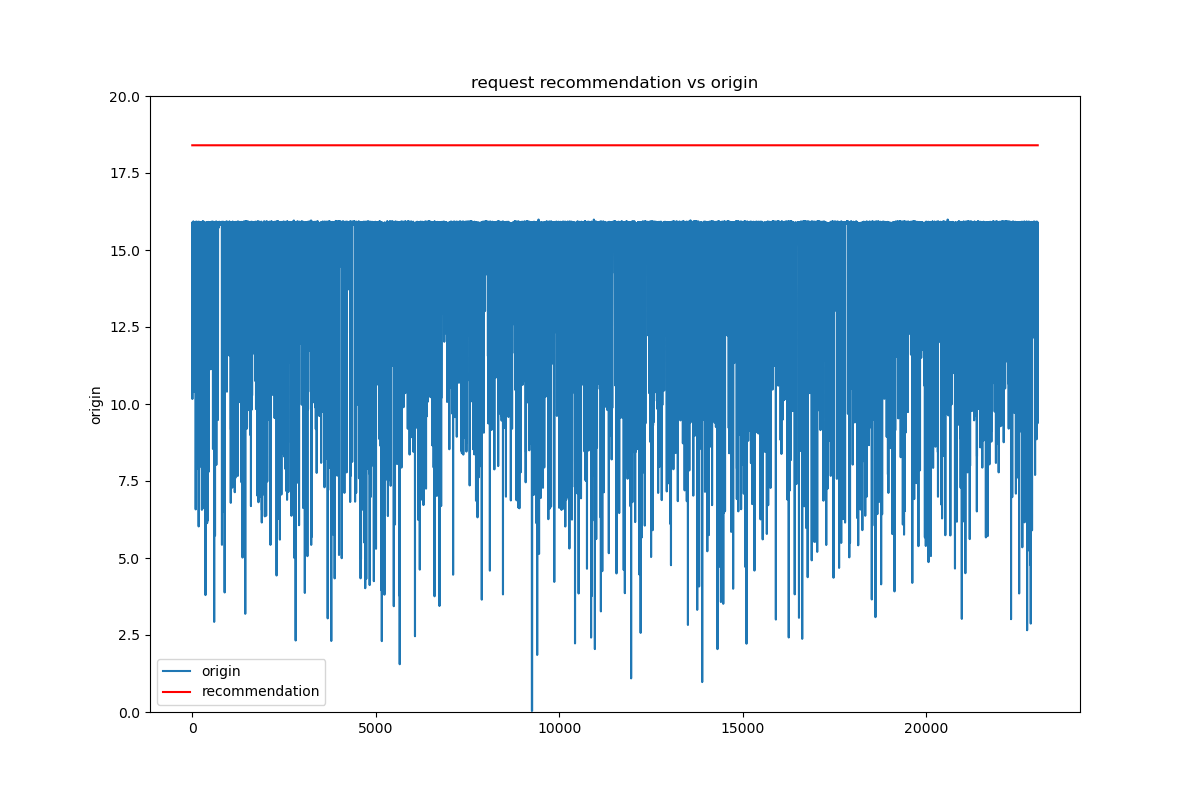

In [10]:
# check cpu request recommendation(one day).
one_day_index = int(24*60*60/30)
week_day_index = int(24*60*60*7/30)
default_margin = 0.15
data = cpu_data_20220418_20220502_0a9obzx3.iloc[0,1:].values
index = len(data)-one_day_index
data_origin = data[index-week_day_index:-one_day_index]
result = percentile_predict(data_origin, 0.99, True,'cpu',margin=default_margin)
result

data_last = data[index-week_day_index:]
x = np.arange(len(data_last))
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(111)
ax1.plot(x, data_last,label='origin')
ax1.set_ylabel('origin')
ax1.set_title("request recommendation vs origin")
ax1.set_ylim((0,20))
ax1.plot(x, result*np.ones(len(data_last)), 'r',label='recommendation')
ax1.legend()
plt.show()

In [11]:
'''
打分规则：
1. 权重 = 后一天的 n 个点，分布在每个小时，每个小时权重依次递减
2. 如果 resource_type 为 memory, 需要对推荐值小于真实值的点进行加大惩罚，尽量 100% 让 memory 不超过 request 值,避免 request 和 limit 设置接近，oom 造成服务挂掉
3. 如果推荐值大于真实值很多,则需要做些许惩罚，进一步约束
'''

'''
Scoring rules:
1. Weight = n points on the next day, distributed in each hour, and the weight decreases in turn each hour
2. If the resource_type is memory, it is necessary to increase the penalty for the points where the recommended value is less than the actual value, try to make the memory less than the request value by 100%, to avoid the request and limit settings being close, and the oom will cause the service to hang up
3. If the recommended value is much larger than the real value, you need to do some punishment to further restrict
'''
import math
def amplify_loss(x, resource_type,epsilon=0.05):
    # 推荐小于实际
    if x < 0:
        if resource_type == "memory":
            if x<-3:
                x=-3
            # oom
            # oom_punalty_coefficient
            return np.exp(1+abs(x/0.8))
        else:
            if x<-10:
                x=-10
            return np.log(0.5-x)/np.log(2.0) + 1
    # 推荐大于实际 太多
    elif x > epsilon:
        if x > 10:
            x=10
        return np.exp((x/5-epsilon)/0.8)
    else:
        return 0

# 这里设置阈值 0.05 如果，超过会做进一步增益,如果 memory request < usage 会做比较大的增益;如果是 cpu request>>usage 会做比较大的增益；看你的倾向性
# 当 loss 为0时得分最高 为 100
def score(recommendation, data, resource_type):
    bins = 24
    length = len(data)
    loss = 0.0
    datas = np.split(data,bins)
    weight = np.arange(1,bins+1,1,dtype=float)
    weight = weight/weight.sum()
    weight = weight[::-1]
    
    for i,data in enumerate(datas):
        for d in data:
            loss += amplify_loss((recommendation-d)/d, resource_type)* weight[i]
        loss = loss/len(data)
    
    return 1.0/(0.01+loss)

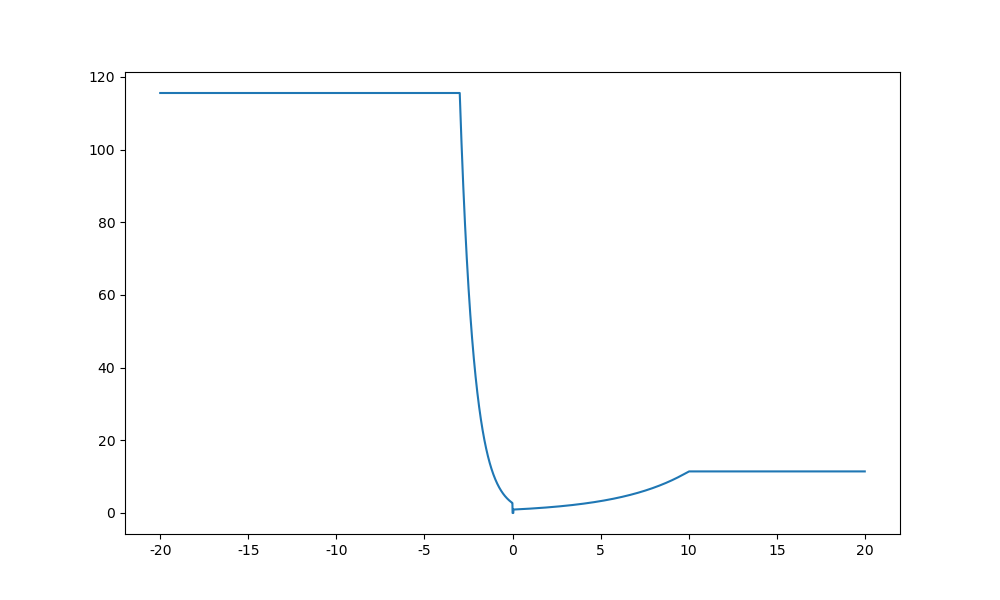

In [12]:
epsilon=0.05
x=np.arange(-20,20,0.01)
y=[amplify_loss(i,'memory') for i in x]
# y=[amplify_scores(i,'cpu') for i in x]
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x,y)
plt.show()

In [13]:
# one day predict
scores = []
for i in range(len(cpu_data_20220418_20220502_0a9obzx3)):
    data = cpu_data_20220418_20220502_0a9obzx3.iloc[i,1:].values
    index = len(data)-one_day_index
    data_origin = data[index-week_day_index:-one_day_index]
    result = percentile_predict(data_origin, 0.99, True,'cpu', default_margin)
    s = score(result, data[index:],"cpu")
    scores.append(s)
    
    
for i in range(len(cpu_data_20220425_20220509_4g9b5b18)):
    data = cpu_data_20220425_20220509_4g9b5b18.iloc[i,1:].values
    index = len(data)-one_day_index
    data_origin = data[index-week_day_index:-one_day_index]
    result = percentile_predict(data_origin, 0.99, True,'cpu',default_margin)
    s = score(result, data[index:],"cpu")
    scores.append(s)

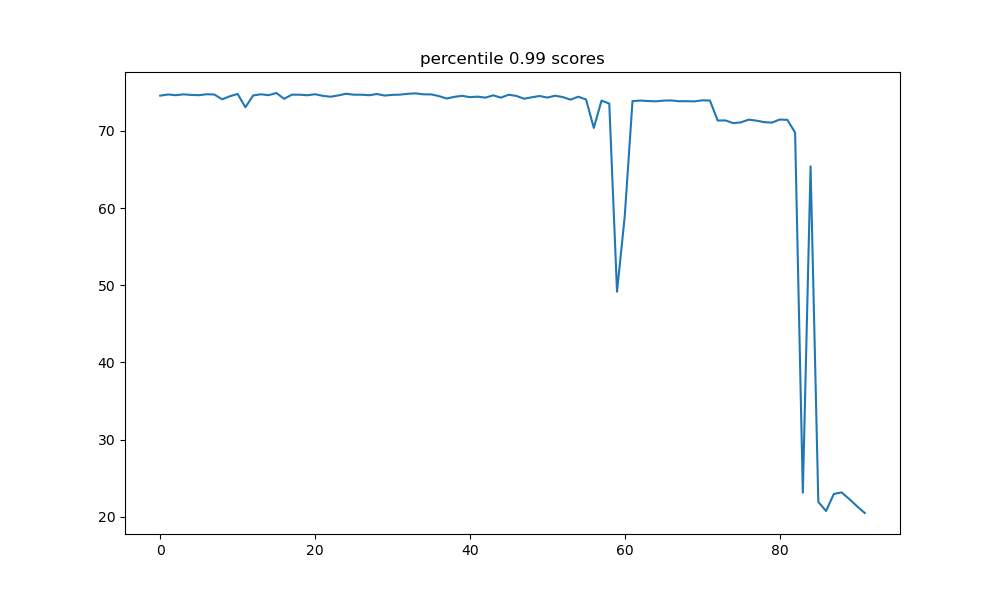

p99 : 74.87838099452226
p95 : 74.79325426400348
p50 : 74.34895814051849
mean :  68.88429374057914
0 : [74.57636308]
1 : [74.73351722]
2 : [74.63551654]
3 : [74.7474616]
4 : [74.67269461]
5 : [74.63787002]
6 : [74.76374292]
7 : [74.72137089]
8 : [74.10503039]
9 : [74.50116409]
10 : [74.79795027]
11 : [73.06964948]
12 : [74.60351798]
13 : [74.75609599]
14 : [74.64089328]
15 : [74.92239821]
16 : [74.16992267]
17 : [74.70220266]
18 : [74.70426166]
19 : [74.62752329]
20 : [74.76245399]
21 : [74.55509029]
22 : [74.43768002]
23 : [74.6068882]
24 : [74.82569114]
25 : [74.70235057]
26 : [74.70116523]
27 : [74.63264619]
28 : [74.78941208]
29 : [74.58899199]
30 : [74.68242611]
31 : [74.71065943]
32 : [74.82196717]
33 : [74.87402764]
34 : [74.74904487]
35 : [74.74078619]
36 : [74.51929721]
37 : [74.20782976]
38 : [74.42677062]
39 : [74.55992149]
40 : [74.3810551]
41 : [74.44987958]
42 : [74.31810123]
43 : [74.62322819]
44 : [74.32213576]
45 : [74.69495525]
46 : [74.54381391]
47 : [74.17932703]
48 

In [14]:
# more is good.
fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(len(scores))
ax.plot(x,scores)
ax.set_title("percentile 0.99 scores")
plt.show()
print("p99 :",np.percentile(scores, 99))
print("p95 :",np.percentile(scores, 95))
print("p50 :",np.percentile(scores, 50))
print("mean : ",np.mean(scores))
for i,score in enumerate(scores):
    print(i,':',score)

[71.48008186]


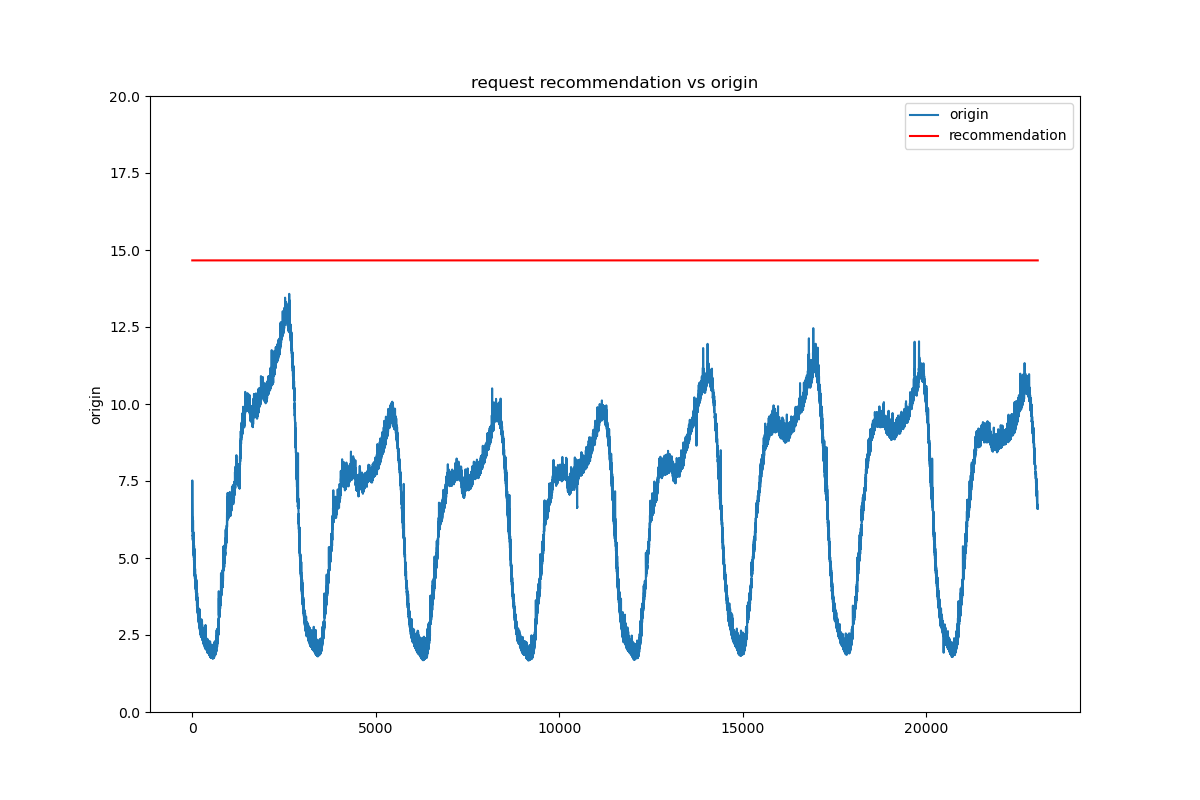

In [15]:
# 为什么第 80 个信号得分低，因为这个是周期性信号，并且波动率较大，导致低谷时的利用率低，影响得分
one_day_index = int(24*60*60/30)
print(scores[80])
data = cpu_data_20220418_20220502_0a9obzx3.iloc[80,1:].values
index = len(data)-one_day_index
data_origin = data[index-week_day_index:-one_day_index]
result = percentile_predict(data_origin, 0.99, True,'cpu',margin=default_margin)
result

data_last = data[index-week_day_index:]
x = np.arange(len(data_last))
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(111)
ax1.plot(x, data_last,label='origin')
ax1.set_ylabel('origin')
ax1.set_title("request recommendation vs origin")
ax1.set_ylim((0,20))
ax1.plot(x, result*np.ones(len(data_last)), 'r',label='recommendation')
ax1.legend()
plt.show()

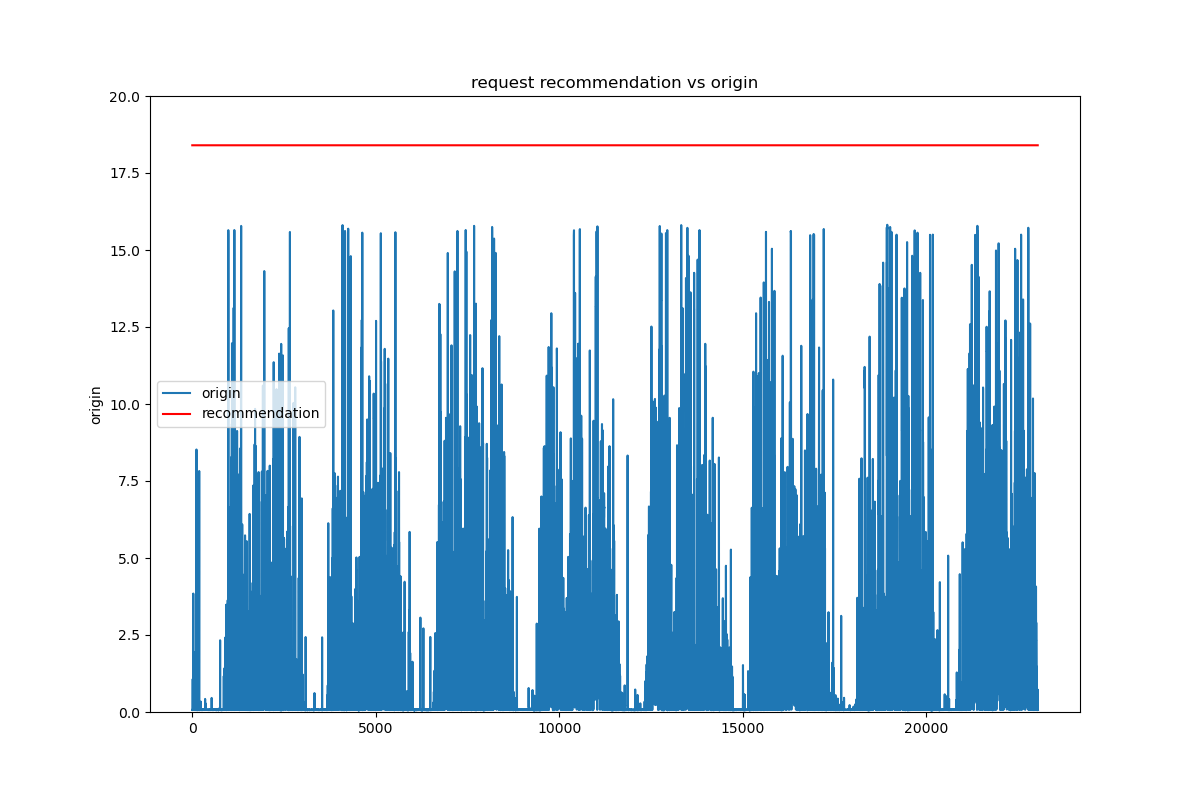

In [16]:
# 为什么第 87 个信号得分低，因为这个是信号的毛刺较大，且是周期性信号，周期为 1day 波动率非常大，导致低谷时的利用率低，影响得分
one_day_index = int(24*60*60/30)
data = cpu_data_20220425_20220509_4g9b5b18.iloc[4,1:].values
index = len(data)-one_day_index
data_origin = data[index-week_day_index:-one_day_index]
result = percentile_predict(data_origin, 0.99, True,'cpu',margin=default_margin)
result

data_last = data[index-week_day_index:]
x = np.arange(len(data_last))
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(111)
ax1.plot(x, data_last,label='origin')
ax1.set_ylabel('origin')
ax1.set_title("request recommendation vs origin")
ax1.set_ylim((0,20))
ax1.plot(x, result*np.ones(len(data_last)), 'r',label='recommendation')
ax1.legend()
plt.show()

In [ ]:
# 看下不同 percentile 以及 margin 对得分的影响
scores_10 = []
for i in range(len(cpu_data_20220418_20220502_0a9obzx3)):
    data = cpu_data_20220418_20220502_0a9obzx3.iloc[i,1:].values
    index = len(data)-one_day_index
    data_origin = data[index-week_day_index:-one_day_index]
    result = percentile_predict(data_origin, 0.99, True,'cpu', margin=0.1)
    s = score(result, data[index:],"cpu")
    scores_10.append(s)
    
    
for i in range(len(cpu_data_20220425_20220509_4g9b5b18)):
    data = cpu_data_20220425_20220509_4g9b5b18.iloc[i,1:].values
    index = len(data)-one_day_index
    data_origin = data[index-week_day_index:-one_day_index]
    result = percentile_predict(data_origin, 0.99, True,'cpu',margin=0.1)
    s = score(result, data[index:],"cpu")
    scores_10.append(s)

In [ ]:
# one day
scores_05 = []
for i in range(len(cpu_data_20220418_20220502_0a9obzx3)):
    data = cpu_data_20220418_20220502_0a9obzx3.iloc[i,1:].values
    index = len(data)-one_day_index
    data_origin = data[index-week_day_index:-one_day_index]
    result = percentile_predict(data_origin, 0.99, True,'cpu', margin=0.05)
    s = score(result, data[index:],"cpu")
    scores_05.append(s)
    
    
for i in range(len(cpu_data_20220425_20220509_4g9b5b18)):
    data = cpu_data_20220425_20220509_4g9b5b18.iloc[i,1:].values
    index = len(data)-one_day_index
    data_origin = data[index-week_day_index:-one_day_index]
    result = percentile_predict(data_origin, 0.99, True,'cpu',margin=0.05)
    s = score(result, data[index:],"cpu")
    scores_05.append(s)

In [ ]:
# one day
scores_percentile_95= []
for i in range(len(cpu_data_20220418_20220502_0a9obzx3)):
    data = cpu_data_20220418_20220502_0a9obzx3.iloc[i,1:].values
    index = len(data)-one_day_index
    data_origin = data[index-week_day_index:-one_day_index]
    result = percentile_predict(data_origin, 0.95, True,'cpu', margin=0.05)
    s = score(result, data[index:],"cpu")
    scores_percentile_95.append(s)
    
    
for i in range(len(cpu_data_20220425_20220509_4g9b5b18)):
    data = cpu_data_20220425_20220509_4g9b5b18.iloc[i,1:].values
    index = len(data)-one_day_index
    data_origin = data[index-week_day_index:-one_day_index]
    result = percentile_predict(data_origin, 0.95, True,'cpu',margin=0.05)
    s = score(result, data[index:],"cpu")
    scores_percentile_95.append(s)

In [ ]:
# one day
scores_percentile_90 = []
for i in range(len(cpu_data_20220418_20220502_0a9obzx3)):
    data = cpu_data_20220418_20220502_0a9obzx3.iloc[i,1:].values
    index = len(data)-one_day_index
    data_origin = data[index-week_day_index:-one_day_index]
    result = percentile_predict(data_origin, 0.90, True,'cpu', margin=0.05)
    s = score(result, data[index:],"cpu")
    scores_percentile_90.append(s)
    
    
for i in range(len(cpu_data_20220425_20220509_4g9b5b18)):
    data = cpu_data_20220425_20220509_4g9b5b18.iloc[i,1:].values
    index = len(data)-one_day_index
    data_origin = data[index-one_day_index:index]
    result = percentile_predict(data_origin, 0.90, True,'cpu',margin=0.05)
    s = score(result, data[index:],"cpu")
    scores_percentile_90.append(s)

In [ ]:
# more is good.
fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(len(scores))
ax.plot(x,scores,label='margin 0.15')
ax.plot(x, scores_10, label='margin 0.10') 
ax.plot(x, scores_05, label='margin 0.05')
ax.plot(x, scores_percentile_90, label='percentile 90') 
ax.plot(x, scores_percentile_95, label='percentile 95')
ax.legend()
ax.set_title("scores")
plt.show()
print("0.15 :",np.percentile(scores, 95))
print("0.10 :",np.percentile(scores_10, 95))
print("0.05 :",np.percentile(scores_05, 95))

In [ ]:
print("0.15 :",np.percentile(scores, 95))
print("0.15 :",np.percentile(scores, 90))
print("0.15 :",np.percentile(scores, 99))
print("0.15 :",np.mean(scores))

In [ ]:
# 第 61 百分比降低后为什么提升这么明显？因为7天中虽然是周期性的但是出现了一定的波动，最大值较大，降低百分比后预测值显著降低
# Why is the increase so obvious after the 61st percent reduction? Because although it is cyclical in 7 days, there are certain fluctuations, the maximum value is large, and the predicted value is significantly reduced after the percentage is reduced
one_day_index = int(24*60*60/30)
data = cpu_data_20220418_20220502_0a9obzx3.iloc[66,1:].values
index = len(data)-one_day_index
data_origin = data[index-week_day_index:-one_day_index]

result = percentile_predict(data_origin, 0.90, True,'cpu',margin=default_margin)
result

data_last = data[index-week_day_index:]
x = np.arange(len(data_last))
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(111)
ax1.plot(x, data_last,label='origin')
ax1.set_ylabel('origin')
ax1.set_title("request recommendation vs origin")
ax1.set_ylim((0,20))
ax1.plot(x, result*np.ones(len(data_last)), 'r',label='recommendation ')
ax1.legend()
plt.show()

## 2.2 Conclusion

percentile 目前应用于：
1. hpa targetUtilization target_pod_cpu_utilization = pod_cpu_usage_p99 / pod_cpu_request
2. cpu/mem resource request 推荐

打分规则：
1. 权重 = 后一天的 n 个点，分布在每个小时，每个小时权重依次递减
2. 如果 resource_type 为 memory, 需要对推荐值小于真实值的点进行加大惩罚，尽量 100% 让 memory 不超过 request 值,避免 request 和 limit 设置接近，oom 造成服务挂掉
3. 如果推荐值大于真实值很多，则需要做些许惩罚，进一步约束


根据得分观察到的现象：
1. 平稳信号的 margin 减小，得分高的基础上可以继续提升
2. 周期性信号，如果波动量较大、毛刺较多，则得分较低；如果最大值较大，会极大的影响得分


可优化调整策略：
1. 如果 cpu 信号的波动小的话，可以减小 margin 或者 percentile ,以达到更高的利用率
2. 如果波动量特别大，如果是整周期的，回溯数据可由 default 7d -> 调整设置为周期时间，同时缩减 margin 
3. 如果波动量较大且非周期，目前没有更优策略

可优化算法：
1. 目前的 crane percentile 使用的桶均为线性桶，可尝试指数桶

AUTOML:
- 超参调优：
    1. margin
    2. analysis 周期时间
    3. 百分比
    4. bucket 数量
    5. bucket size
    6. epsilon
- 目标：
    1. scores 得分

## 2.2 Conclusion

percentile is currently applied to:
1. hpa targetUtilization target_pod_cpu_utilization = pod_cpu_usage_p99 / pod_cpu_request
2. cpu/mem resource request recommended

Scoring rules:
1. Weight = n points on the next day, distributed in each hour, and the weight decreases in turn each hour
2. If the resource_type is memory, it is necessary to increase the penalty for the points whose recommended value is less than the actual value. Try to make the memory less than the request value by 100%, to avoid the request and limit settings being close, and the oom will cause the service to hang.
3. If the recommended value is much larger than the real value, you need to do some punishment to further restrict


Observations based on the score:
1. The margin of the stable signal is reduced, and it can continue to improve on the basis of high score
2. For periodic signals, if the fluctuation is large and there are many glitches, the score will be low; if the maximum value is large, the score will be greatly affected


Optimal adjustment strategy:
1. If the fluctuation of the cpu signal is small, you can reduce the margin or percentile to achieve higher utilization
2. If the fluctuation is particularly large, if it is a whole cycle, the retrospective data can be set to the cycle time by default 7d -> adjustment, while reducing the margin
3. If the volatility is large and non-cyclical, there is currently no better strategy

Optimal algorithm:
1. The buckets used by the current crane percentile are all linear buckets, but you can try index buckets

AUTOML:
- Hyperparameter tuning:
    1. margin
    2. Analysis cycle time
    3. Percentage
    4. Number of buckets
    5. bucket size
    6. epsilon
- Target:
    1. scores

### Future Work

1. 如果将 request 推荐的值变动更加的频繁，或许可以更灵活的设置  margin，并且百分比算法也可获取贴近的值, crane 先分析 -> ExecuteMission -> 后推荐，anaylysis 可分析一次或者周期性分析，周期 1d, 而 vpa 默认是 1min， 调节小呢？
    N day 数据关乎业务峰值，N 一般为8
    https://www.infoq.cn/article/z40lmwmtoyvecq6tpoik 
    1. vpa default 会针对 oom 事件将转换成样本 max(mem_last_used+100m, mem_last_used*1.2)，evpa 呢？
    2. vpa low, highbound 指标，evpa 目前没有会有哪些问题？ default_target = max(p90*margin, pod_min_cpu_cores/N) low=max(p50*1+1/length_1_day,pod_min_cpu_cores/N)  high = max(p95*1+1/length_1_day,pod_min_cpu_cores/N) N 为 pod container 数量 -> ContainerResourcePolicy 进一步处理
2. 内存得分情况
3. 不同半衰期影响
4. 长期观察，因为真实业务不可能每天调整 request 值
5. request cover 峰值，有无浪费，指导 margin ,tkex 真实数据
6. 后续可以实现 vpa 推荐算法，和 crane request 推荐算法做有效性对比，通过离线评估让用户对该算法更有信心
7. 实验 automl 自动调优
    

1. If the value recommended by the request is changed more frequently, the margin may be set more flexibly, and the percentage algorithm can also obtain a close value. Crane first analyzes -> ExecuteMission -> and then recommends, analysis can analyze once or periodically , the period is 1d, and the default value of vpa is 1min. What about the small adjustment?
    N day data is related to business peak, N is generally 8
    https://www.infoq.cn/article/z40lmwmtoyvecq6tpoik
    1. vpa default will convert the oom event into a sample max(mem_last_used+100m, mem_last_used*1.2), what about evpa?
    2. Vpa low, highbound indicators, what problems will evpa not have at present? default_target = max(p90*margin, pod_min_cpu_cores/N) low=max(p50*1+1/length_1_day,pod_min_cpu_cores/N) high = max(p95*1+1/length_1_day,pod_min_cpu_cores/N) N is the number of pod containers- > ContainerResourcePolicy for further processing
2. Memory score
3. Different half-life effects
4. Long-term observation, because it is impossible for real business to adjust the request value every day
5. Request cover peak, whether there is waste, guide margin, tkex real data
6. In the future, the vpa recommendation algorithm can be implemented, and the effectiveness of the crane request recommendation algorithm can be compared to make users more confident in the algorithm through offline evaluation.
7. Experiment with automl auto-tuning